In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
sns.set()

In [2]:
with open('P1- BankStatements.json') as P1:
    data=json.load(P1)

In [3]:
type(data)

dict

In [4]:
len(data)

1

In [5]:
df1=pd.DataFrame(data)
df1

,Account
type,deposit
maskedAccNumber,XXXX6461
version,1.1
linkedAccRef,02f28b8d-d8a3-43d7-88c6-5fabb2e51541
xmlns,http://api.rebit.org.in/FISchema/deposit
xsi:schemaLocation,http://api.rebit.org.in/FISchema/deposit.xsd
xmlns:xsi,http://www.w3.org/2001/XMLSchema-instance
Profile,"{'Holders': {'type': 'SINGLE', 'Holder': {'nam..."
Summary,"{'currentBalance': '761.41', 'currency': 'INR'..."
Transactions,"{'startDate': '2023-05-31', 'endDate': '2024-0..."


### 1) Transaction Analysis: 
#### a) What is the total number of transactions made over the year?

In [6]:
tra=data['Account']['Transactions']['Transaction']
len(tra)

985

In [7]:
df=pd.DataFrame(tra)
df = df.sort_values(by='transactionTimestamp')
df.head()

,type,mode,amount,currentBalance,transactionTimestamp,valueDate,txnId,narration,reference
0,DEBIT,CARD,100.0,2180.80,2023-06-27T09:40:19+05:30,2023-06-27,S39488701,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA
1,DEBIT,CARD,170.0,2010.80,2023-06-28T09:51:57+05:30,2023-06-28,S76862822,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA
2,DEBIT,CARD,500.0,1510.80,2023-07-26T10:04:00+05:30,2023-07-26,S31451661,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA
3,CREDIT,OTHERS,15.0,1525.80,2023-08-06T11:10:38+05:30,2023-07-31,S66463256,51888100006461IntPd01-05-2023 to 31-07-2023,NA
4,DEBIT,ATM,1000.0,525.80,2023-08-07T17:13:13+05:30,2023-08-07,S18475743,ATM/CASH/321917012791/XXXXXXXXXXXX8896,NA


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   type                  985 non-null    object
 1   mode                  985 non-null    object
 2   amount                985 non-null    object
 3   currentBalance        985 non-null    object
 4   transactionTimestamp  985 non-null    object
 5   valueDate             985 non-null    object
 6   txnId                 985 non-null    object
 7   narration             985 non-null    object
 8   reference             985 non-null    object
dtypes: object(9)
memory usage: 69.4+ KB


In [9]:
# # Save DataFrame to CSV
# csv_file = 'transactions.csv'
# df.to_csv(csv_file, index=False)

# # Code to download the CSV file if running in a Jupyter notebook
# from IPython.display import FileLink
# FileLink(csv_file)

#### b) What is the distribution of transaction amounts (e.g., small vs. large transactions)?(define small and large transactions by yourself)

In [10]:
df['amount'] = df['amount'].astype(float)
am=df['amount']
am.describe()

count      985.000000
mean       855.492802
std       3007.515100
min          1.000000
25%         40.000000
50%        160.000000
75%        500.000000
max      45000.000000
Name: amount, dtype: float64

In [11]:
am.median()

160.0

In [12]:
q1 = am.quantile(0.25)
q3 = am.quantile(0.75)

q1, q3

(40.0, 500.0)

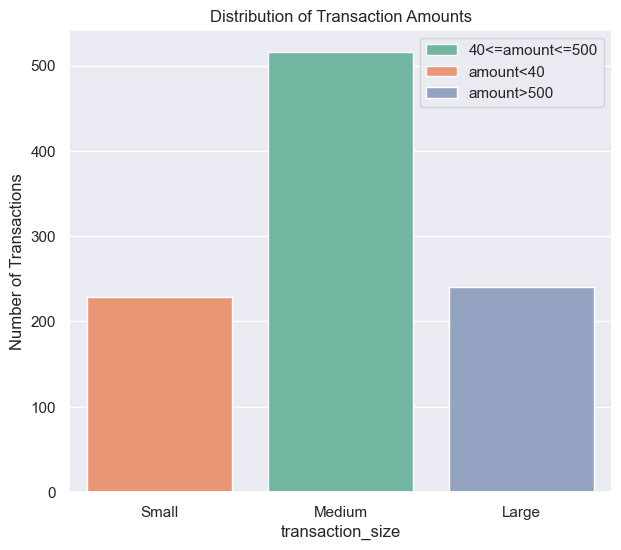

In [13]:
# Define small, medium, and large transactions
def categorize_transaction(amount):
    if amount < q1:
        return 'Small'
    elif amount <= q3:
        return 'Medium'
    else:
        return 'Large'

df['transaction_size'] = df['amount'].apply(categorize_transaction)

plt.figure(figsize=(7, 6))
sns.countplot(x='transaction_size', data=df,hue='transaction_size', palette='Set2',order=['Small','Medium','Large'])
plt.legend(['40<=amount<=500','amount<40','amount>500'])

plt.title('Distribution of Transaction Amounts')
plt.ylabel('Number of Transactions')

plt.show()

#### c) Analyze the frequency of different transaction types (debit vs. credit).

In [14]:
df['type'].value_counts()

type
DEBIT     695
CREDIT    290
Name: count, dtype: int64

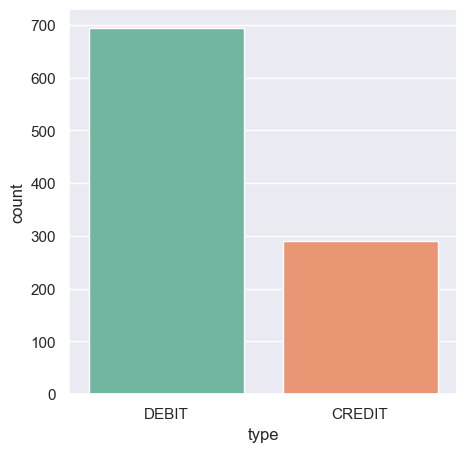

In [15]:
plt.figure(figsize=(5,5))
sns.countplot(x='type', data=df,hue='type', palette='Set2')
plt.show()

### 2) Balance Analysis

In [16]:
df['currentBalance']=df['currentBalance'].astype(float)
cb=df['currentBalance']

In [17]:
df['valueDate']=pd.to_datetime(df["valueDate"],format='mixed')
vd=df['valueDate']
df.head()

,type,mode,amount,currentBalance,transactionTimestamp,valueDate,txnId,narration,reference,transaction_size
0,DEBIT,CARD,100.0,2180.8,2023-06-27T09:40:19+05:30,2023-06-27,S39488701,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA,Medium
1,DEBIT,CARD,170.0,2010.8,2023-06-28T09:51:57+05:30,2023-06-28,S76862822,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA,Medium
2,DEBIT,CARD,500.0,1510.8,2023-07-26T10:04:00+05:30,2023-07-26,S31451661,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA,Medium
3,CREDIT,OTHERS,15.0,1525.8,2023-08-06T11:10:38+05:30,2023-07-31,S66463256,51888100006461IntPd01-05-2023 to 31-07-2023,NA,Small
4,DEBIT,ATM,1000.0,525.8,2023-08-07T17:13:13+05:30,2023-08-07,S18475743,ATM/CASH/321917012791/XXXXXXXXXXXX8896,NA,Large


#### a) What is the trend of the account balance over time?
#### b) Identify any periods with significant changes in the account balance.

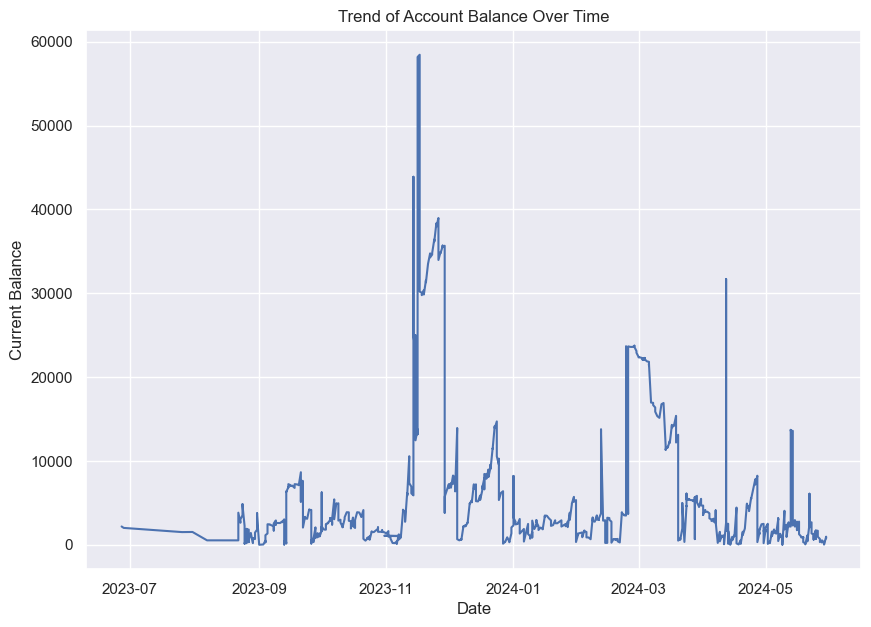

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(vd, cb, linestyle='-')
plt.xlabel('Date')
plt.ylabel('Current Balance')
plt.title('Trend of Account Balance Over Time')
plt.show()

###  3) Spending Patterns
#### a) What are the main categories of expenses (e.g., fuel, Ecommerce, food, shopping, ATM withdrawals, UPI transactions)?

In [19]:
md=df['mode']

In [20]:
md.unique()

array(['CARD', 'OTHERS', 'ATM', 'UPI', 'CASH'], dtype=object)

In [21]:
md.value_counts()

mode
UPI       789
OTHERS    188
CARD        4
ATM         3
CASH        1
Name: count, dtype: int64

#### b) Analyze the frequency and amount of spending in each category.

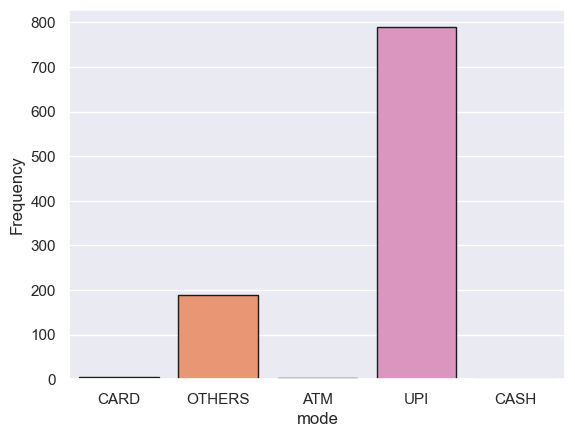

In [22]:
sns.countplot(x='mode',data=df,hue='mode',palette='Set2',edgecolor='k')
plt.ylabel('Frequency')
plt.show()

In [23]:
sum_by_mode=df.groupby('mode')['amount'].sum().reset_index()

In [24]:
sum_by_mode

,mode,amount
0,ATM,13500.00
1,CARD,830.00
2,CASH,45000.00
3,OTHERS,196237.51
4,UPI,587092.90


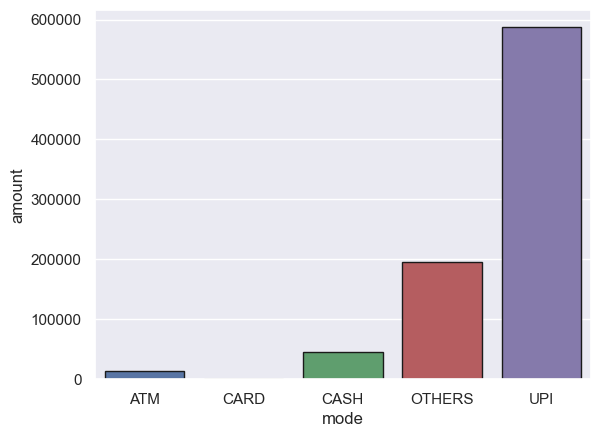

In [25]:
sns.barplot(x='mode',y='amount', data=sum_by_mode,hue='mode',edgecolor='k')
plt.show()

### 4.  Income Analysis: 
#### a) What are the main sources of income (e.g., salary, UPI credits)?

In [26]:
credit_transactions = df[df['type'] == 'CREDIT'].copy()
credit_transactions['narration'].unique()

array(['51888100006461IntPd01-05-2023 to 31-07-2023',
       'UPI/323441197152/114914/UPI/8795417446ybl/Paym',
       'UPI/323457106254/122004/UPI/9264998949barodamp',
       'UPI/323567840697/105122/UPI/kimoroybl/Payment',
       'UPI/323602109737/113218/UPI/9701028466ibl/Paym',
       'UPI/323618540670/123136/UPI/9580229953axl/Paym',
       'UPI/323628493930/165253/UPI/7479893801ibl/Paym',
       'UPI/323679308931/182222/UPI/7731035157ibl/Paym',
       'UPI/360354864566/160316/UPI/mayankbhai73590oki',
       'IMPS/P2A/323716492303/PHONEPEPRIVATEL/IMPSAXB9111',
       'UPI/323784208807/161921/UPI/goog-paymentokaxis',
       'NEFT-AXNPN32379238097-PHONEPE PRIVATE LIMITED',
       'IMPS/P2A/323718489753/PHONEPEPRIVATEL/IMPSAXB9111',
       'UPI/323802960783/192600/UPI/9369558521ybl/Paym',
       'UPI/323823651280/194229/UPI/rajanbhai271okhdfc',
       'UPI/323840766196/203616/UPI/shivampandit199999',
       'UPI/323906382845/192938/UPI/atulyadav16469axl/',
       'IMPS/P2A/324020918876/

In [27]:
source_mapping = {
    '5188': 'Interest',
    'UPI/': 'UPI',
    'IMPS': 'IMPS',
    'NEFT': 'NEFT',
    'BY C': 'Cash'
}
credit_transactions['source'] = credit_transactions['narration'].apply(lambda x: source_mapping.get(x[:4], 'Other'))
credit_transactions.head()

,type,mode,amount,currentBalance,transactionTimestamp,valueDate,txnId,narration,reference,transaction_size,source
3,CREDIT,OTHERS,15.0,1525.8,2023-08-06T11:10:38+05:30,2023-07-31,S66463256,51888100006461IntPd01-05-2023 to 31-07-2023,NA,Small,Interest
6,CREDIT,UPI,3000.0,3524.8,2023-08-22T11:49:13+05:30,2023-08-22,S90667553,UPI/323441197152/114914/UPI/8795417446ybl/Paym,NA,Large,UPI
7,CREDIT,UPI,300.0,3824.8,2023-08-22T12:20:04+05:30,2023-08-22,S92051775,UPI/323457106254/122004/UPI/9264998949barodamp,NA,Medium,UPI
9,CREDIT,UPI,400.0,3024.8,2023-08-23T10:51:21+05:30,2023-08-23,S25232032,UPI/323567840697/105122/UPI/kimoroybl/Payment,NA,Medium,UPI
10,CREDIT,UPI,500.0,3524.8,2023-08-24T11:32:18+05:30,2023-08-24,S65206796,UPI/323602109737/113218/UPI/9701028466ibl/Paym,NA,Medium,UPI


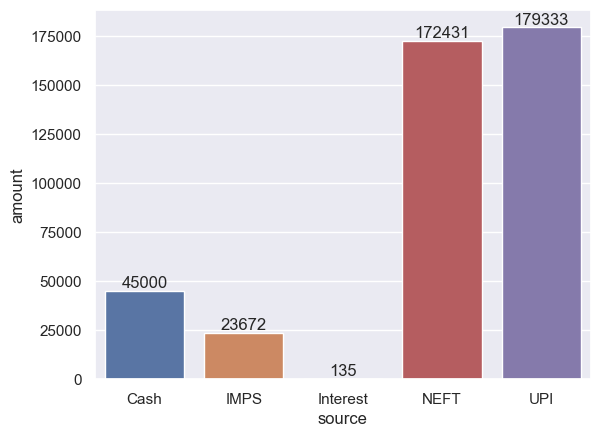

In [28]:
Income_Based = credit_transactions.groupby('source')['amount'].sum().reset_index()
ax=sns.barplot(x='source', y='amount', data=Income_Based,hue='source')
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

#### b) Identify any patterns in the timing and amount of income received.

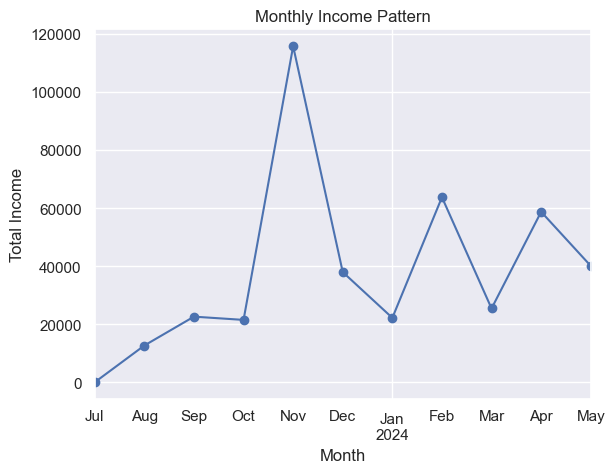

In [29]:
# 4.2 Patterns in Timing and Amount of Income Received
credit_transactions['month'] = credit_transactions['valueDate'].dt.to_period('M')
monthly_income = credit_transactions.groupby('month')['amount'].sum()

monthly_income.plot(kind='line',marker='o')
plt.xlabel('Month')
plt.ylabel('Total Income')
plt.title('Monthly Income Pattern')
plt.grid(True)
plt.show()

### 5. Alert Generation
#### a) Identify any unusual or suspicious transactions.

In [30]:
df['currentBalance'].describe()

count      985.000000
mean      5901.308721
std       8670.950436
min          0.800000
25%       1174.800000
50%       2723.110000
75%       5834.110000
max      58450.800000
Name: currentBalance, dtype: float64

#### b) Generate alerts for low balance or high expenditure periods.

In [31]:
# 1) Identify Unusual Transactions

# Calculating the Z-scores of the transaction amounts to identify outliers
df['amount_zscore'] = zscore(df['amount'].abs())
unusual_transactions = df[df['amount_zscore'] > 3]


# 2) Alerts for Low Balance
low_balance_threshold = 1174.8  # 25th Percentile (25%): 1174.800000
low_balance_alerts = df[df['currentBalance'] < low_balance_threshold]


# 3: Alerts for High Expenditure
# Calculating the rolling sum of expenditures over a 7-day window

df['transactionTimestamp'] = pd.to_datetime(df['transactionTimestamp'])
df = df.sort_values(by='transactionTimestamp')
df['expenditure'] = df.apply(lambda x: x['amount'] if x['type'] == 'DEBIT' else 0, axis=1)
df.set_index('transactionTimestamp', inplace=True)
df['rolling_expenditure'] = df['expenditure'].rolling('7D').sum()
df.reset_index(inplace=True)


# Defining a high expenditure threshold
rolling_mean = df['rolling_expenditure'].mean()
rolling_std = df['rolling_expenditure'].std()

high_expenditure_threshold = rolling_mean + 2 * rolling_std
high_expenditure_alerts = df[df['rolling_expenditure'] > high_expenditure_threshold]

### Unusual Transcations

In [32]:
print("\nUnusual Transactions:\n")
print(unusual_transactions[['transactionTimestamp', 'amount', 'amount_zscore']])


Unusual Transactions:

          transactionTimestamp   amount  amount_zscore
275  2023-11-14T18:31:11+05:30  37999.0      12.356505
277  2023-11-14T18:49:41+05:30  16500.0       5.204448
285  2023-11-15T17:48:21+05:30  10000.0       3.042097
291  2023-11-16T15:51:14+05:30  45000.0      14.685523
295  2023-11-17T16:34:54+05:30  21000.0       6.701459
332  2023-11-29T16:15:33+05:30  19000.0       6.036121
333  2023-11-29T17:09:47+05:30  12700.0       3.940304
353  2023-12-05T15:50:06+05:30  13000.0       4.040105
535  2024-02-12T13:22:57+05:30  10000.0       3.042097
537  2024-02-13T14:01:51+05:30  10000.0       3.042097
570  2024-02-24T18:55:15+05:30  20000.0       6.368790
572  2024-02-25T11:08:34+05:30  20000.0       6.368790
576  2024-02-25T20:08:58+05:30  20000.0       6.368790
648  2024-03-20T18:56:48+05:30  12000.0       3.707436
743  2024-04-12T20:47:44+05:30  30000.0       9.695483
744  2024-04-12T20:50:06+05:30  30000.0       9.695483
884  2024-05-13T06:54:41+05:30  11530.0  

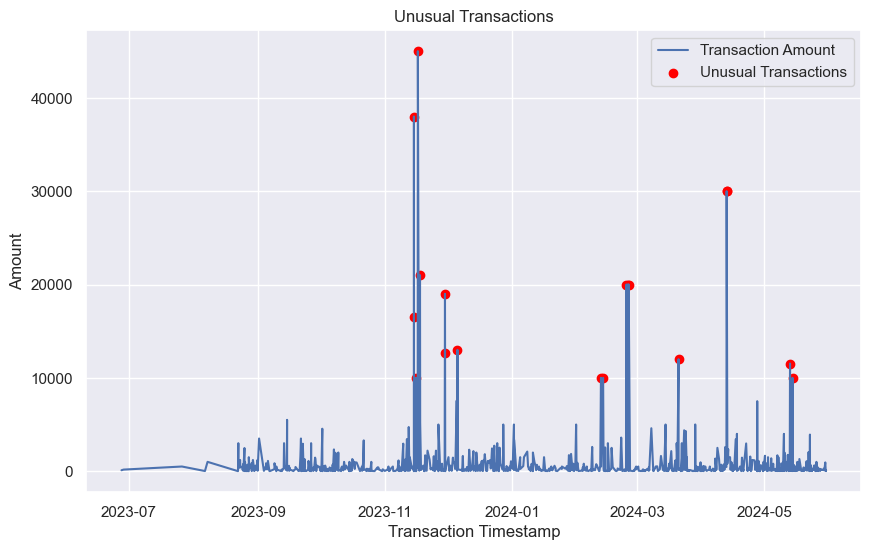

In [44]:
# Plot of unusual transactions
plt.figure(figsize=(10, 6))
plt.plot(df['transactionTimestamp'], df['amount'], label='Transaction Amount')
plt.scatter(unusual_transactions['transactionTimestamp'], unusual_transactions['amount'], color='red', label='Unusual Transactions')
plt.title('Unusual Transactions')
plt.xlabel('Transaction Timestamp')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Low balance alerts

In [34]:
print("\nLow Balance Alerts:\n")
print(low_balance_alerts[['transactionTimestamp', 'currentBalance']])


Low Balance Alerts:

          transactionTimestamp  currentBalance
4    2023-08-07T17:13:13+05:30          525.80
5    2023-08-22T08:05:06+05:30          524.80
18   2023-08-25T10:39:35+05:30          794.80
19   2023-08-25T12:03:11+05:30          674.80
20   2023-08-25T16:03:16+05:30         1154.80
..                         ...             ...
980  2024-05-29T17:57:40+05:30           23.41
981  2024-05-30T05:07:05+05:30          961.41
982  2024-05-30T09:58:24+05:30          901.41
983  2024-05-30T13:30:30+05:30          771.41
984  2024-05-30T13:38:20+05:30          761.41

[246 rows x 2 columns]


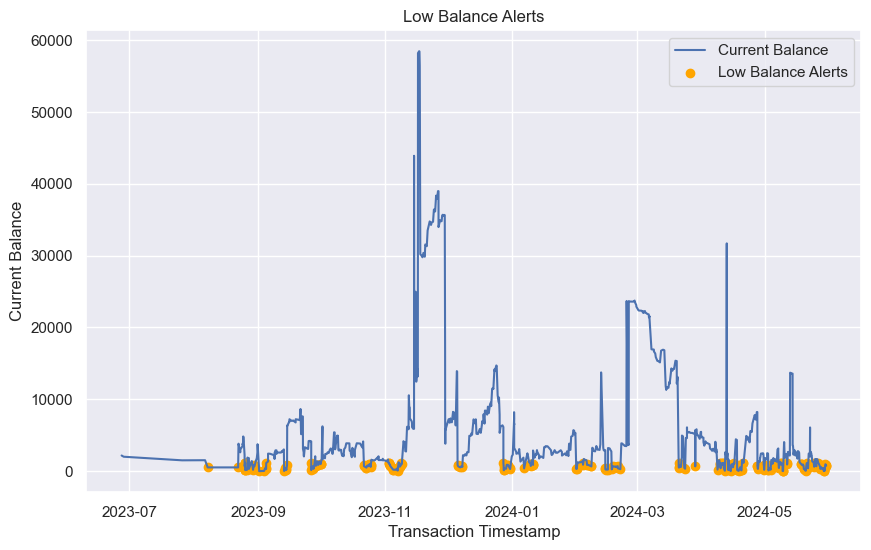

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(df['transactionTimestamp'], df['currentBalance'], label='Current Balance')
plt.scatter(low_balance_alerts['transactionTimestamp'], low_balance_alerts['currentBalance'], color='orange', label='Low Balance Alerts')
plt.title('Low Balance Alerts')
plt.xlabel('Transaction Timestamp')
plt.ylabel('Current Balance')
plt.legend()
plt.show()

### High expenditure alerts

In [36]:
print("\nHigh Expenditure Alerts:\n")
print(high_expenditure_alerts[['transactionTimestamp', 'rolling_expenditure']])


High Expenditure Alerts:

         transactionTimestamp  rolling_expenditure
285 2023-11-15 17:48:21+05:30              39601.0
286 2023-11-15 19:08:47+05:30              40101.0
287 2023-11-15 20:56:36+05:30              40111.0
288 2023-11-16 05:34:18+05:30              40061.0
289 2023-11-16 12:33:01+05:30              40061.0
..                        ...                  ...
762 2024-04-17 20:39:39+05:30              41010.9
763 2024-04-18 13:09:44+05:30              40235.0
764 2024-04-19 06:58:16+05:30              39885.0
765 2024-04-19 19:35:04+05:30              39335.0
766 2024-04-19 20:23:27+05:30              39355.0

[68 rows x 2 columns]


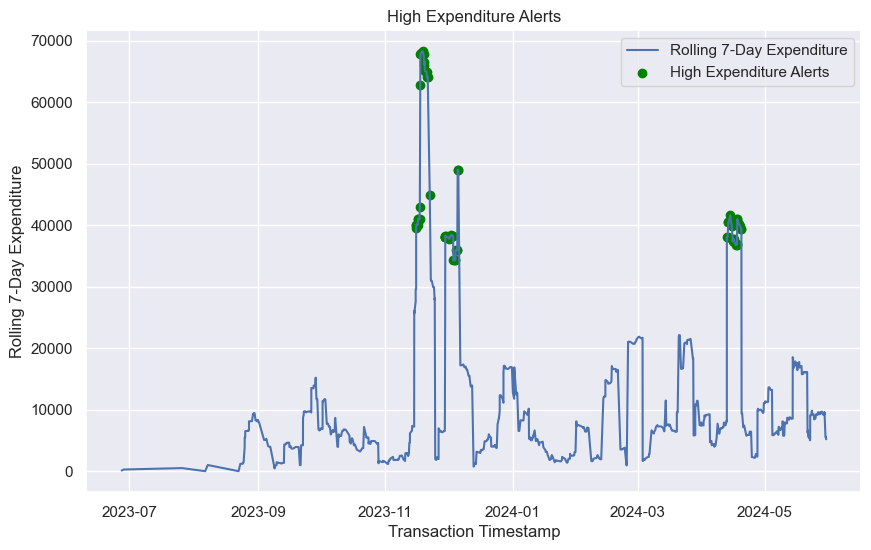

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df['transactionTimestamp'], df['rolling_expenditure'], label='Rolling 7-Day Expenditure')
plt.scatter(high_expenditure_alerts['transactionTimestamp'], high_expenditure_alerts['rolling_expenditure'], color='green', label='High Expenditure Alerts')
plt.title('High Expenditure Alerts')
plt.xlabel('Transaction Timestamp')
plt.ylabel('Rolling 7-Day Expenditure')
plt.legend()
plt.show()

In [38]:
df.head()

,transactionTimestamp,type,mode,amount,currentBalance,valueDate,txnId,narration,reference,transaction_size,amount_zscore,expenditure,rolling_expenditure
0,2023-06-27 09:40:19+05:30,DEBIT,CARD,100.0,2180.8,2023-06-27,S39488701,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA,Medium,-0.251329,100.0,100.0
1,2023-06-28 09:51:57+05:30,DEBIT,CARD,170.0,2010.8,2023-06-28,S76862822,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA,Medium,-0.228042,170.0,270.0
2,2023-07-26 10:04:00+05:30,DEBIT,CARD,500.0,1510.8,2023-07-26,S31451661,PRCR/MS NEHA FILLING STATIO/FARRUKHAB,NA,Medium,-0.118262,500.0,500.0
3,2023-08-06 11:10:38+05:30,CREDIT,OTHERS,15.0,1525.8,2023-07-31,S66463256,51888100006461IntPd01-05-2023 to 31-07-2023,NA,Small,-0.279606,0.0,0.0
4,2023-08-07 17:13:13+05:30,DEBIT,ATM,1000.0,525.8,2023-08-07,S18475743,ATM/CASH/321917012791/XXXXXXXXXXXX8896,NA,Large,0.048073,1000.0,1000.0
